In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from tqdm import tqdm
from tensor_utils import outer, CPD1, tensor_contraction
rng = np.random.default_rng(14159)

In [2]:
# Set parameters
N_points = 50 # number of points
N_rep = 10 # number of repetition per point

beta = 3
epsilon = .2
c = np.array([1/6, 2/6, 3/6])

# Modes on which to contract on singular vector
# modes = np.array([True, False, False]) # only the first mode
# modes = np.array([True, False, True]) # the first and second modes
modes = np.array([True, True, True]) # each mode

d = len(c) # order of the tensor
n = np.round(np.outer(np.logspace(1.9, 2.5, N_points), c)).astype(int) # growing tensor shapes
nn = np.sum(n, axis=1)

In [3]:
# Computations
val = np.zeros((N_points, N_rep))
axes = np.arange(d)
for i in tqdm(range(N_points)):
    x = []
    for ell in range(d):
        # x[ell] is chosen uniformly at random on the unit sphere
        x.append(rng.standard_normal(n[i, ell]))
        x[ell] /= np.linalg.norm(x[ell])
    P = beta*outer(x) # rank-one perturbation
    for rep in range(N_rep):
        N = rng.standard_normal(n[i]) # generate noise
        T = P+N/nn[i] # signal-plus-noise tensor
        B = rng.binomial(1, epsilon, size=n[i]) # Bernoulli mask
        sigma, svecs = CPD1(T*B) # best rank-one approximation
        observed = tensor_contraction(P*B, [svecs[ell] if modes[ell] else x[ell] for ell in range(d)], axes) # compute contraction
        conjectured = epsilon*np.prod([x[ell]@svecs[ell] if modes[ell] else 1 for ell in range(d)])*beta # conjectured value
        val[i, rep] = observed-conjectured # error

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:29<00:00,  1.72it/s]


In [4]:
# Regressions
val_mean = np.mean(np.abs(val), axis=1)
val_var = np.var(val, axis=1)
linreg_mean = linregress(np.log(nn), np.log(val_mean))
linreg_var = linregress(np.log(nn), np.log(val_var))

print("Power decay")
print("Mean", linreg_mean.slope)
print("Variance", linreg_var.slope)

Power decay
Mean -2.0387446510156666
Variance -3.7146416291052464


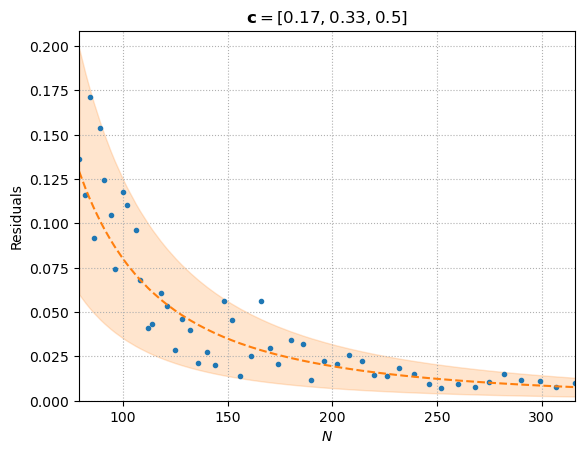

In [5]:
# Plot residuals
y_mean = np.exp(linreg_mean.intercept)*nn**linreg_mean.slope
y_var = np.exp(linreg_var.intercept)*nn**linreg_var.slope
plt.plot(nn, val_mean, ls='', marker='.', color='C0')
plt.plot(nn, y_mean, ls='--', color='C1')
plt.fill_between(nn, y_mean-np.sqrt(y_var), y_mean+np.sqrt(y_var), color='C1', alpha=.2)
plt.grid(ls=':')
plt.xlim(nn[0], nn[-1])
plt.ylim(bottom=0)
plt.xlabel("$N$")
plt.ylabel("Residuals")
plt.title("$\\mathbf{{c}} = {{{}}}$".format(list(np.round(c, 2))))
plt.show()